In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch.nn.functional import softmax

In [ ]:
!pip install transformers[sentencepiece]==4.10.0 datasets --quiet


     |████████████████████████████████| 2.8 MB 5.3 MB/s 
     |████████████████████████████████| 311 kB 45.2 MB/s 
     |████████████████████████████████| 67 kB 4.9 MB/s 
     |████████████████████████████████| 596 kB 43.0 MB/s 
     |████████████████████████████████| 895 kB 40.2 MB/s 
     |████████████████████████████████| 3.3 MB 32.3 MB/s 
     |████████████████████████████████| 1.1 MB 45.2 MB/s 
     |████████████████████████████████| 133 kB 44.9 MB/s 
     |████████████████████████████████| 1.1 MB 35.3 MB/s 
     |████████████████████████████████| 243 kB 36.9 MB/s 
     |████████████████████████████████| 271 kB 39.7 MB/s 
     |████████████████████████████████| 94 kB 2.8 MB/s 
     |████████████████████████████████| 144 kB 48.8 MB/s 


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-offensive")

model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-offensive")


Downloading:   0%|          | 0.00/593 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
!pip install tqdm


In [ ]:
from tqdm.notebook import tqdm, trange


In [ ]:
tweet_df = pd.read_csv("/content/drive/MyDrive/total_data_twitter.csv", lineterminator='\n')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (11,17,24,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
subset_df = tweet_df[tweet_df['language'].isin(['hi','en','ta'])]
hin_df = subset_df[subset_df['language'] == 'en']

In [ ]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [ ]:
hin_df.shape

(815998, 43)

In [ ]:
tweets=hin_df["tweet"].tolist()


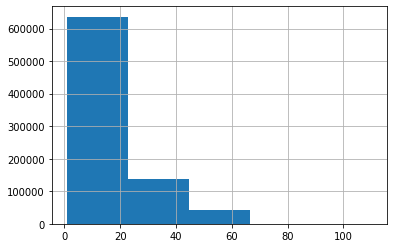

In [ ]:
seq_len = [len(i.split()) for i in tweets]

pd.Series(seq_len).hist(bins = 5)

In [ ]:
hin_df['len']=seq_len

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
c=hin_df[hin_df['len']>70]
c.shape

(136, 44)

In [ ]:
import torch

In [ ]:
device = torch.device('cuda')
model.eval()
_ = model.to(device)

In [ ]:
label_map= {
        0: 'None', 
        1: 'Hate'
    }

In [ ]:
torch.cuda.empty_cache()


In [ ]:
offense_list = []
offense_confidence = []
bs = 16
for x in trange(len(hin_df['tweet'])//bs+1):
    batch_x = list(hin_df['tweet'][x*bs:x*bs+bs])
    clean_x = [preprocess(tweet) for tweet in batch_x]
    encoded_input = tokenizer(clean_x, return_tensors='pt', padding=True, truncation=True, max_length=70)
    encoded_input.to(device)
    output = model(**encoded_input)
    out = softmax(output[0].data, dim=-1).detach().cpu()
    labels = [label_map[i] for i in torch.argmax(out,-1).numpy()]
    offense_list.extend(labels)
    for x_ind, y_ind in enumerate(torch.argmax(out,-1)):
        offense_confidence.append(round(out[x_ind, y_ind].item(),2))
    if(x%1000 == 0):
        print('GPU memory: %.1f' % (torch.cuda.memory_allocated() // 1024 ** 2))

  0%|          | 0/51000 [00:00<?, ?it/s]

GPU memory: 1219.0
GPU memory: 1203.0
GPU memory: 1963.0
GPU memory: 1258.0
GPU memory: 1965.0
GPU memory: 1099.0
GPU memory: 1287.0
GPU memory: 1119.0
GPU memory: 1239.0
GPU memory: 1850.0
GPU memory: 1203.0
GPU memory: 1240.0
GPU memory: 1614.0
GPU memory: 1579.0
GPU memory: 1970.0
GPU memory: 1204.0
GPU memory: 1101.0
GPU memory: 1733.0
GPU memory: 1157.0
GPU memory: 1211.0
GPU memory: 1731.0
GPU memory: 1142.0
GPU memory: 1144.0
GPU memory: 1217.0
GPU memory: 1903.0
GPU memory: 1239.0
GPU memory: 1121.0
GPU memory: 1355.0
GPU memory: 1223.0
GPU memory: 1732.0
GPU memory: 1238.0
GPU memory: 1976.0
GPU memory: 1718.0
GPU memory: 1683.0
GPU memory: 1212.0
GPU memory: 1121.0
GPU memory: 1975.0
GPU memory: 1210.0
GPU memory: 1974.0
GPU memory: 1867.0
GPU memory: 1640.0
GPU memory: 1238.0
GPU memory: 1978.0
GPU memory: 1312.0
GPU memory: 1227.0
GPU memory: 1239.0
GPU memory: 1976.0
GPU memory: 1205.0
GPU memory: 1240.0
GPU memory: 1792.0
GPU memory: 1213.0


In [ ]:
hin_df['eng_offenseeval_confidence']=offense_confidence
hin_df['eng_offenseeval_label']=offense_list

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
hin_df

,Unnamed: 0,_id,tweet_id,tweet,image_url,s3_url,tweet_url,user_id,timestamp_of_creation,language,reply,repost,timestamp_of_scraping,type,search,content_type,conversation_id,date,geo,hashtags,likes_count,mentions,name,near,place,quote_url,replies_count,retweet_date,retweet_id,retweets_count,source,time,timezone,trans_dest,trans_src,translate,urls,user_rt,user_rt_id,username,video,date_created,time_created,len,eng_trac1_confidence,eng_trac1_label
0,0,619dbbaade83f8b60cc9ac45,1331295308492402694,Y does police torture in “Custody”. B’cos it c...,[],NaN,https://twitter.com/Rajeevkh007/status/1331295...,181170852,2020-11-24 23:25:10 IST,en,0,0,20211124094226,hashtag,#RheaChakraborty,text,1.331295e+18,2020-11-24,NaN,"['bhartisingharrested', 'bhartisingh', 'bharti...",2.0,[],Rajeev Khandelwal,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,23:25:10,530.0,NaN,NaN,NaN,[],NaN,NaN,rajeevkh007,0.0,NaN,NaN,20,0.90,Hate
1,1,619dbbaade83f8b60cc9ac46,1331281784873517057,Proof strangulation mark on Sushant's neck &am...,[],NaN,https://twitter.com/Ushie31572809/status/13312...,1315949161598971906,2020-11-24 22:31:26 IST,en,0,0,20211124094226,hashtag,#RheaChakraborty,text,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,0.84,Hate
2,2,619dbbaade83f8b60cc9ac47,1331270877128781825,"#RheaChakraborty So many days passed, CBI coul...",[],NaN,https://twitter.com/Utpal24378053/status/13312...,1303037551289102336,2020-11-24 21:48:05 IST,en,0,0,20211124094226,hashtag,#RheaChakraborty,text,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,0.85,Hate
3,3,619dbbaade83f8b60cc9ac48,1331248718214033411,How is #RheaChakraborty ??,[],NaN,https://twitter.com/IWillSpeakToo/status/13312...,1098874110241689600,2020-11-24 20:20:02 IST,en,0,0,20211124094226,hashtag,#RheaChakraborty,text,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,0.54,None
4,4,619dbbaade83f8b60cc9ac49,1331226810579750918,All members of yuva shiv sena party of the lik...,[],NaN,https://twitter.com/surabhi82707088/status/133...,1323921548281966593,2020-11-24 18:52:59 IST,en,0,0,20211124094226,hashtag,#RheaChakraborty,text,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38,0.97,Hate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1560053,560053,61e51a402584e2832c8b5335,1079508688627474432,Both murdered by cowardly twisted ethnic natio...,['https://pbs.twimg.com/media/DvstWJtXcAA7Lf-....,https://s3.ap-south-1.amazonaws.com/ogbv.tattl...,https://twitter.com/StrategNL/status/107950868...,93410612,2018-12-31 04:15:02 IST,en,[],False,20220117125656,keyword,nationalists,image,1.079509e+18,NaN,NaN,[],1.0,[],StrategNL🌎🇳🇱🌍🇪🇺🌏 aka Ronald JH Elzenga ⚔️☮︎,NaN,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,530.0,NaN,NaN,NaN,[],NaN,NaN,strategnl,1.0,2018-12-31,04:15:02,28,0.96,Hate
1560056,560056,61e51a402584e2832c8b5336,1079508591726522368,@e0a4093c6d394e7 @laruedupass @AndrewKnight226...,[],NaN,https://twitter.com/PaulWhelan745/status/10795...,582867073,2018-12-31 04:14:39 IST,en,"[{'screen_name': 'laruedupass', 'name': 'Stur ...",False,20220117125656,keyword,nationalists,text,1.079093e+18,NaN,NaN,[],0.0,[],Paul Whelan,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,530.0,NaN,NaN,NaN,[],NaN,NaN,paulwhelan745,0.0,2018-12-31,04:14:39,22,0.54,None
1560256,560256,61e51a860843dffd91b22a55,1079214709457412096,@ShayarSalman @ela_mishra #चाटुकार of the year...,[],NaN,https://twitter.com/iamstkhan/status/107921470...,1046645529856364544,2018-12-30 08:46:52 IST,en,"[{'screen_name': 'ShayarSalman', 'name': 'Salm...",False,20220117125806,keyword,चाटुकार,text,1.079084e+18,NaN,NaN,"['चाटुकार', 'award']",0.0,[],Tabrez khan🇮🇳,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,530.0,NaN,NaN,NaN,[],NaN,NaN,iamst

In [ ]:
hin_df.to_csv('eng_offenseeval_final.csv')

In [ ]:
from google.colab import files
hin_df.to_csv('eng_offenseeval_final.csv')
!cp eng_offenseeval_final.csv "/content/drive/My Drive/"
